<a href="https://colab.research.google.com/github/Mahirtayeb1/Citrus-Leaf-Disease-Detection-Using-CNN/blob/main/Custom_CNN_Augmented_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import glob
import keras
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import preprocessing, linear_model
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model, get_file
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
# !pip install Augmentor
# !pip install split-folders[full]
# !pip install Augmentor Pillow

2024-01-18 04:15:22.525541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 04:15:24.305766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-18 04:15:24.305932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-18 04:15:24.305940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
import os
import tensorflow as tf

# Set TF_CPP_MIN_LOG_LEVEL to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Rest of your code
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.11.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
visualCnn_path = '/mnt/d/Undergrad_thesis/visualkeras_cnn'

In [ ]:
weights_path = '/mnt/d/Undergrad_thesis/h5_ncleaves'

In [ ]:
root_path = '/mnt/d/Undergrad_thesis/new_citrus_leaves'
dataset_path = os.path.join(root_path,"dataset") #"/content/drive/MyDrive/Thesis P3/new_citrus_leaves"

In [ ]:
num_of_images = {}

for dir in os.listdir(dataset_path):
  num_of_images[dir] = len(os.listdir(os.path.join(dataset_path, dir)))

In [ ]:
os.getcwd()

'/home/mafatay'

In [ ]:
num_of_images.items()

dict_items([('Black spot', 171), ('canker', 163), ('greening', 204), ('new_healthy_citrus', 149)])

In [ ]:
src = os.listdir(dataset_path)
src

['Black spot', 'canker', 'greening', 'new_healthy_citrus']

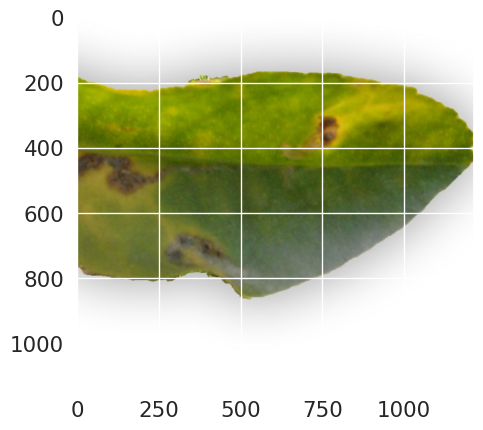

In [ ]:
temp_dir = os.path.join(root_path, 'split_aug', 'train', 'aug_Black spot')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[0]))
plt.imshow(img)

In [ ]:
cv2.imread(os.path.join(temp_dir,os.listdir(temp_dir)[0])).shape

(1133, 1216, 3)

In [ ]:
split_aug_path = os.path.join(root_path, 'split_aug') #"/content/drive/MyDrive/Undergrad Thesis/Aug_split_fix"
fnames = os.listdir(split_aug_path)
len(fnames)

3

In [ ]:
fnames

['test', 'train', 'val']

In [ ]:
fnames
split_aug = os.listdir(os.path.join(split_aug_path, fnames[0]))
split_aug

['aug_Black spot', 'aug_canker', 'aug_greening', 'aug_new_healthy_citrus']

In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))  # Dropout for regularization

    model.add(Dense(4, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten

# def create_custom_model():
#     # Load the pre-trained VGG16 model (excluding the top layer)
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Freeze the layers of the pre-trained model
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Create a Sequential model
#     model = Sequential()

#     # Add the pre-trained VGG16 base model
#     model.add(base_model)

#     # Flatten the output of the VGG16 base model
#     model.add(Flatten())

#     # Dense layers for classification
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))  # 4 classes: canker, black spot, greening, healthy

#     return model

# # Create the model
# # model = create_custom_model()

# # Compile the model
# #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 128)     

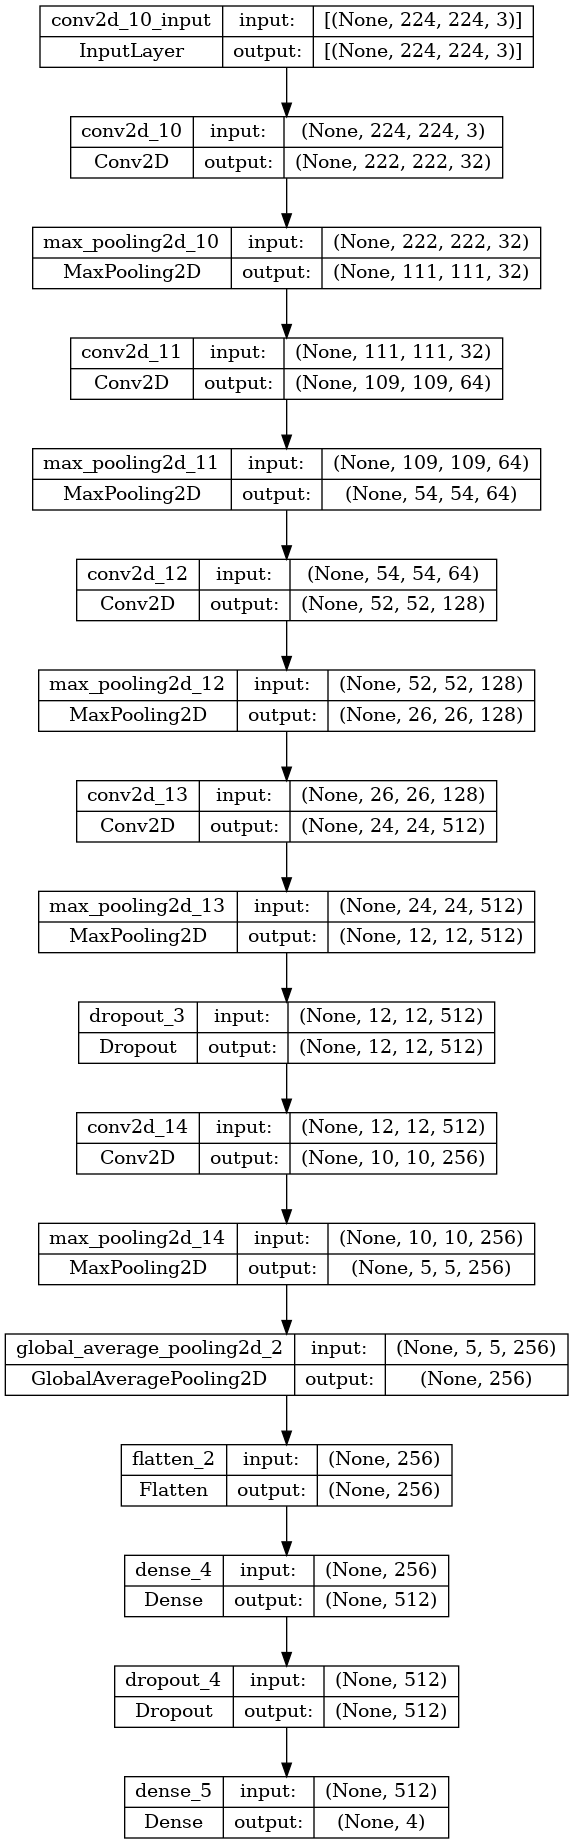

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Using 'categorical' for multi-class classification
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1956 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 424 images belonging to 4 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/20


2024-01-09 09:52:14.760744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/61 [==============================] - 35s 536ms/step - loss: 0.8858 - accuracy: 0.5608 - val_loss: 0.8569 - val_accuracy: 0.5865 - lr: 6.0000e-04
Epoch 2/20
61/61 [==============================] - 33s 534ms/step - loss: 0.6139 - accuracy: 0.6845 - val_loss: 0.5882 - val_accuracy: 0.6899 - lr: 6.0000e-04
Epoch 3/20
61/61 [==============================] - 33s 536ms/step - loss: 0.6637 - accuracy: 0.6632 - val_loss: 0.5076 - val_accuracy: 0.7067 - lr: 6.0000e-04
Epoch 4/20
61/61 [==============================] - 33s 533ms/step - loss: 0.5104 - accuracy: 0.7141 - val_loss: 0.4931 - val_accuracy: 0.7163 - lr: 6.0000e-04
Epoch 5/20
61/61 [==============================] - 32s 521ms/step - loss: 0.4853 - accuracy: 0.7365 - val_loss: 0.4485 - val_accuracy: 0.7404 - lr: 6.0000e-04
Epoch 6/20
61/61 [==============================] - 33s 540ms/step - loss: 0.4246 - accuracy: 0.7698 - val_loss: 0.4195 - val_accuracy: 0.8029 - lr: 6.0000e-04
Epoch 7/20
61/61 [==============================] -

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weights_path,'New_Custom_cnn2.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 4s 247ms/step - loss: 0.1440 - accuracy: 0.9505
Test Accuracy: 0.9504716992378235


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.973557710647583
Corresponding Training Accuracy: 0.9490644335746765


In [ ]:
loaded_model = load_model(os.path.join(weights_path,'New_Custom_cnn2.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 4s 238ms/step - loss: 0.1440 - accuracy: 0.9505
Test Accuracy: 0.9504716992378235


14/14 [==============================] - 3s 234ms/step


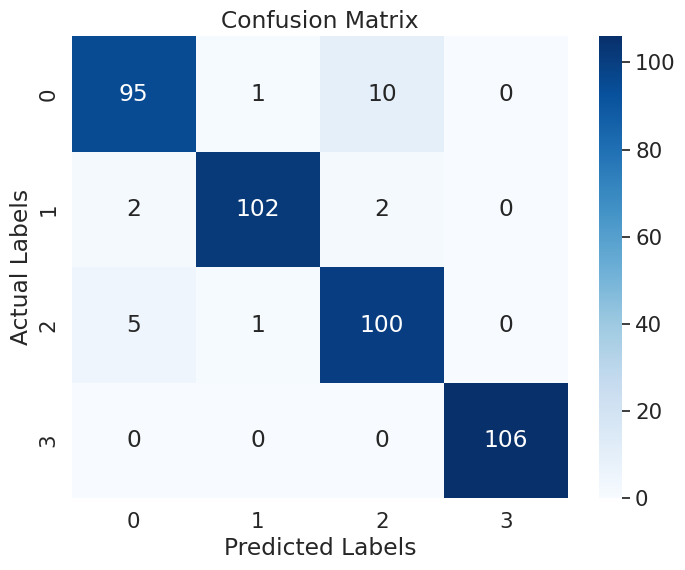

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       106
           1       0.98      0.96      0.97       106
           2       0.89      0.94      0.92       106
           3       1.00      1.00      1.00       106

    accuracy                           0.95       424
   macro avg       0.95      0.95      0.95       424
weighted avg       0.95      0.95      0.95       424



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

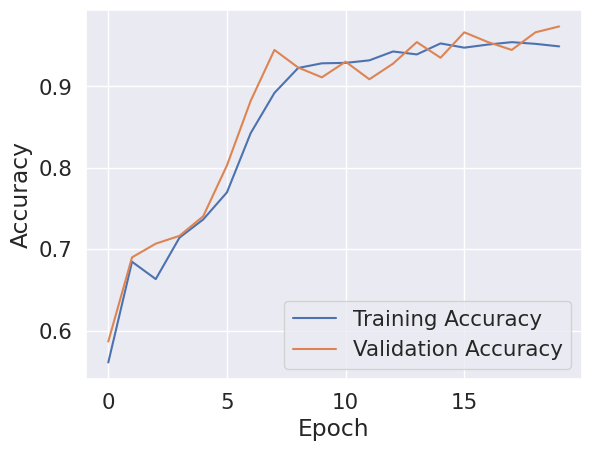

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trail Custom CNN

In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.25))

    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.25))  # Dropout for regularization

    model.add(Dense(4, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 26, 26, 128)     

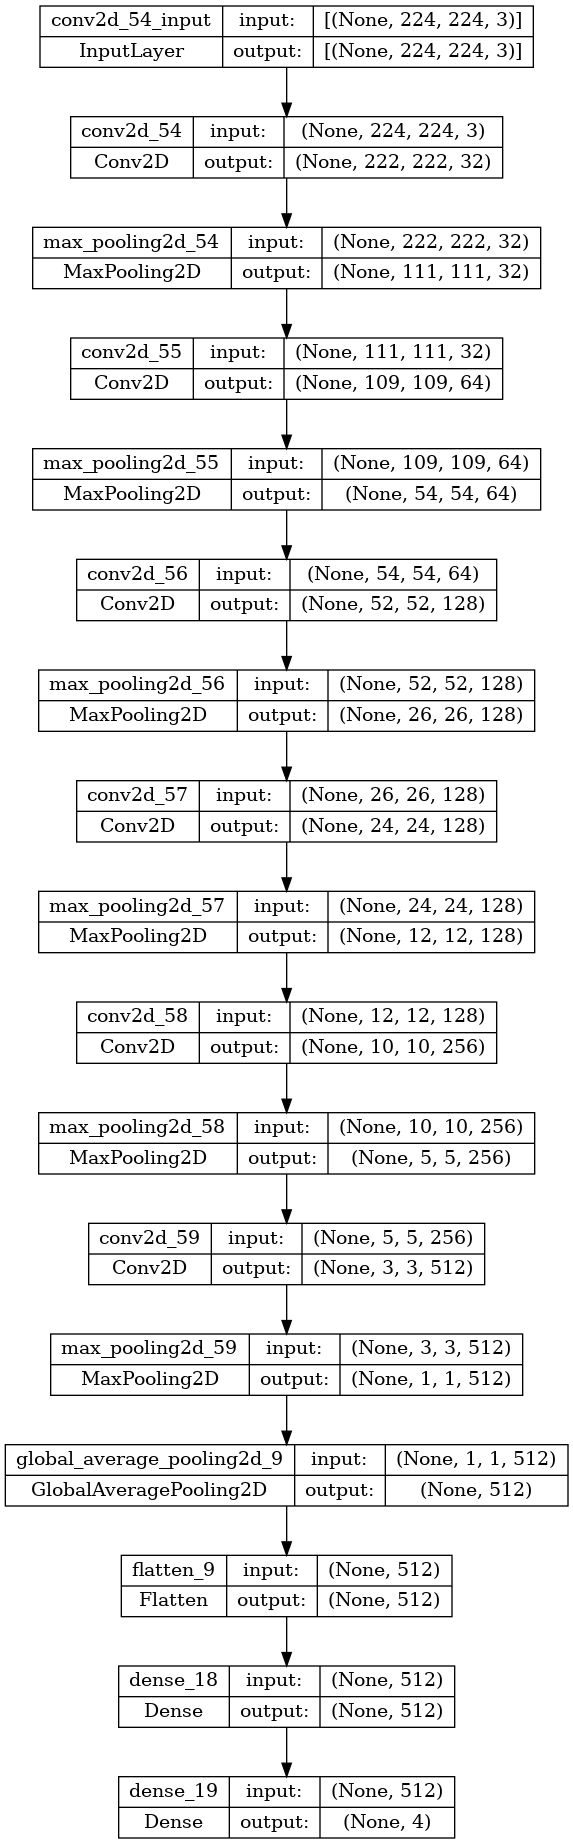

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Using 'categorical' for multi-class classification
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1956 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 424 images belonging to 4 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/20
61/61 [==============================] - 35s 537ms/step - loss: 0.9467 - accuracy: 0.5213 - val_loss: 0.8666 - val_accuracy: 0.5649 - lr: 5.0000e-04
Epoch 2/20
61/61 [==============================] - 32s 522ms/step - loss: 0.7026 - accuracy: 0.6632 - val_loss: 0.6636 - val_accuracy: 0.6514 - lr: 5.0000e-04
Epoch 3/20
61/61 [==============================] - 32s 532ms/step - loss: 0.6226 - accuracy: 0.6804 - val_loss: 0.6683 - val_accuracy: 0.6803 - lr: 5.0000e-04
Epoch 4/20
61/61 [==============================] - 32s 522ms/step - loss: 0.5894 - accuracy: 0.6830 - val_loss: 0.5372 - val_accuracy: 0.6923 - lr: 5.0000e-04
Epoch 5/20
61/61 [==============================] - 31s 509ms/step - loss: 0.5285 - accuracy: 0.7110 - val_loss: 0.7102 - val_accuracy: 0.6538 - lr: 5.0000e-04
Epoch 6/20
61/61 [==============================] - 32s 520ms/step - loss: 0.5489 - accuracy: 0.7173 - val_loss: 0.6418 - val_accuracy: 0.6587 - lr: 5.0000e-04
Epoch 7/20
61/61 [======================

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weights_path,'NewTrail_Custom_cnn2.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 5s 350ms/step - loss: 0.1196 - accuracy: 0.9575
Test Accuracy: 0.9575471878051758


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.9759615659713745
Corresponding Training Accuracy: 0.9511434435844421


In [ ]:
loaded_model = load_model(os.path.join(weights_path,'NewTrail_Custom_cnn2.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 4s 245ms/step - loss: 0.1196 - accuracy: 0.9575
Test Accuracy: 0.9575471878051758


14/14 [==============================] - 4s 261ms/step


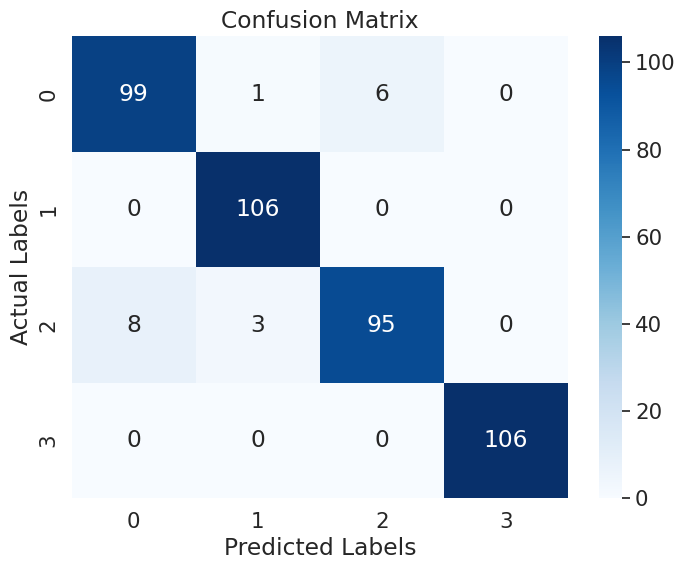

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       106
           1       0.96      1.00      0.98       106
           2       0.94      0.90      0.92       106
           3       1.00      1.00      1.00       106

    accuracy                           0.96       424
   macro avg       0.96      0.96      0.96       424
weighted avg       0.96      0.96      0.96       424



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

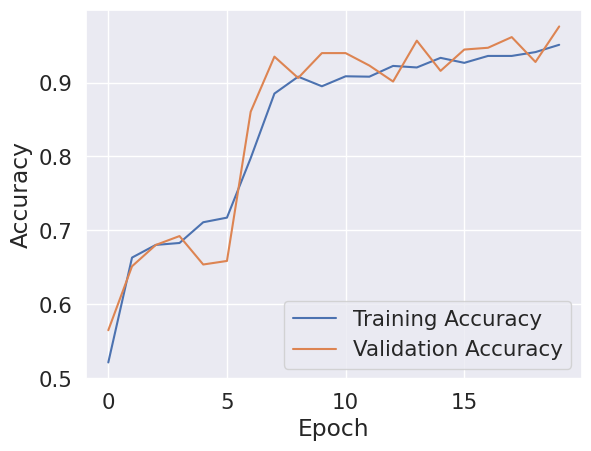

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# def create_model():
#     model = Sequential()

#     # Convolutional layers
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.5))

#     # model.add(Conv2D(128, (3, 3), activation='relu'))
#     # model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))


#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(GlobalAveragePooling2D())

#     # Flatten layer
#     model.add(Flatten())

#     # Dense layers
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.25))  # Dropout for regularization

#     model.add(Dense(4, activation='softmax'))

#     # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#     return model

tuning

In [ ]:
tuneModel_path = '/mnt/d/Undergrad_thesis'

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(hp.Int('units', min_value=128, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout for regularization

    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    directory= os.path.join(tuneModel_path,'keras_tuner_dir'),  # Directory to store the results
    project_name='CitrusNet'
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Trial 5 Complete [00h 06m 32s]
val_accuracy: 0.949999988079071

Best val_accuracy So Far: 0.961904764175415
Total elapsed time: 00h 32m 33s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Epoch 1/20
62/62 [==============================] - 21s 305ms/step - loss: 1.0475 - accuracy: 0.6002 - val_loss: 0.6527 - val_accuracy: 0.6643
Epoch 2/20
62/62 [==============================] - 19s 307ms/step - loss: 0.5177 - accuracy: 0.7408 - val_loss: 0.4115 - val_accuracy: 0.8071
Epoch 3/20
62/62 [==============================] - 19s 309ms/step - loss: 0.3980 - accuracy: 0.8344 - val_loss: 0.2460 - val_accuracy: 0.9024
Epoch 4/20
62/62 [==============================] - 19s 307ms/step - loss: 0.2658 - accuracy: 0.8988 - val_loss: 0.4276 - val_accuracy: 0.8310
Epoch 5/20
62/62 [==============================] - 20s 318ms/step - loss: 0.2201 - accuracy: 0.9223 - val_loss: 0.2226 - val_accuracy: 0.8976
Epoch 6/20
62/62 [==============================] - 19s 311ms/step - loss: 0.1783 - accuracy: 0.9294 - val_loss: 0.1664 - val_accuracy: 0.9381
Epoch 7/20
62/62 [==============================] - 20s 320ms/step - loss: 0.1114 - accuracy: 0.9617 - val_loss: 0.5992 - val_accuracy: 0.8262

In [ ]:
train_dir = os.path.join(split_aug_path, 'train')
test_dir = os.path.join(split_aug_path, 'test')
val_dir = os.path.join(split_aug_path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # DenseNet input size
    batch_size=32,
    class_mode='categorical',  # For 5 classes
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1956 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 424 images belonging to 4 classes.


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Output layer with 5 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Trail CNN ##

In [ ]:
# def create_model():
#     model = Sequential()

#     # Convolutional layers
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     #model.add(Dropout(0.25))

#     # model.add(Conv2D(256, (3, 3), activation='relu'))
#     # model.add(MaxPooling2D((2, 2)))
#     # # model.add(Dropout(0.25))


#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.1))

#     model.add(GlobalAveragePooling2D())

#     # Flatten layer
#     model.add(Flatten())

#     # Dense layers
#     model.add(Dense(512, activation='relu'))
#     # model.add(Dropout(0.25))  # Dropout for regularization

#     model.add(Dense(4, activation='softmax'))

#     # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#     return model

In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.1))

    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.15))  # Dropout for regularization

    model.add(Dense(4, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 26, 26, 128)    

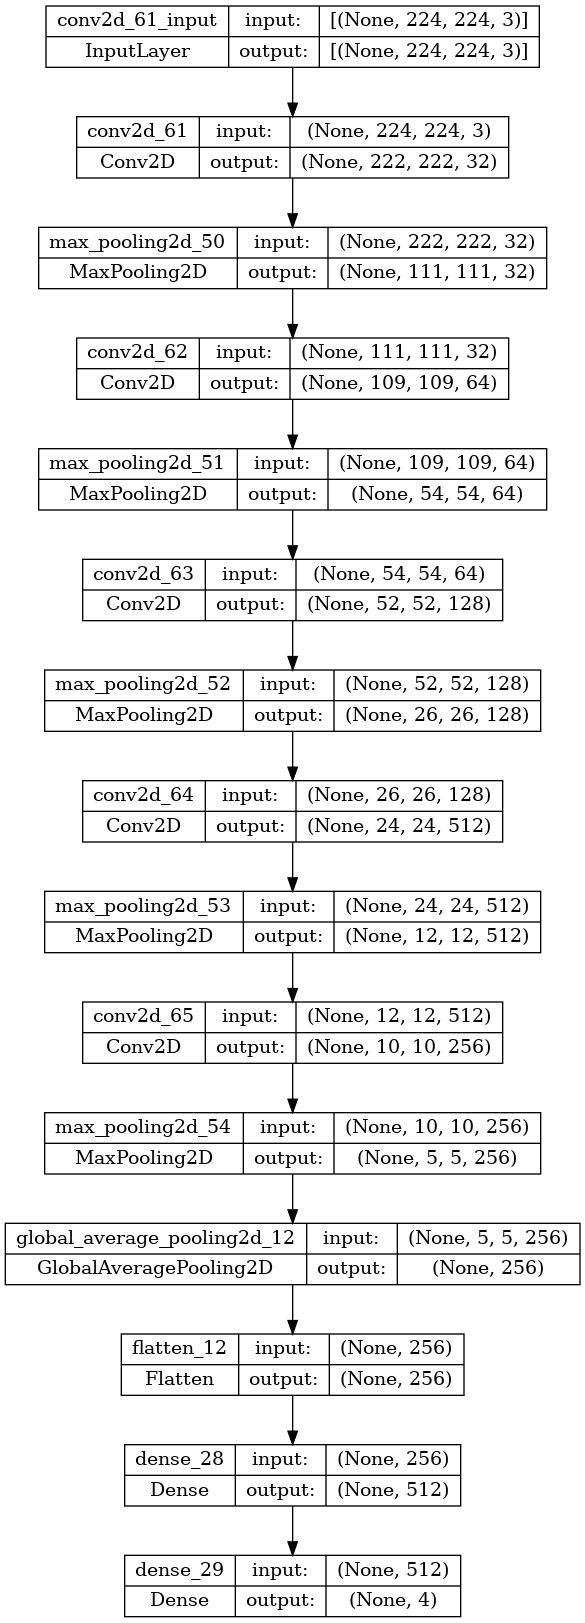

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

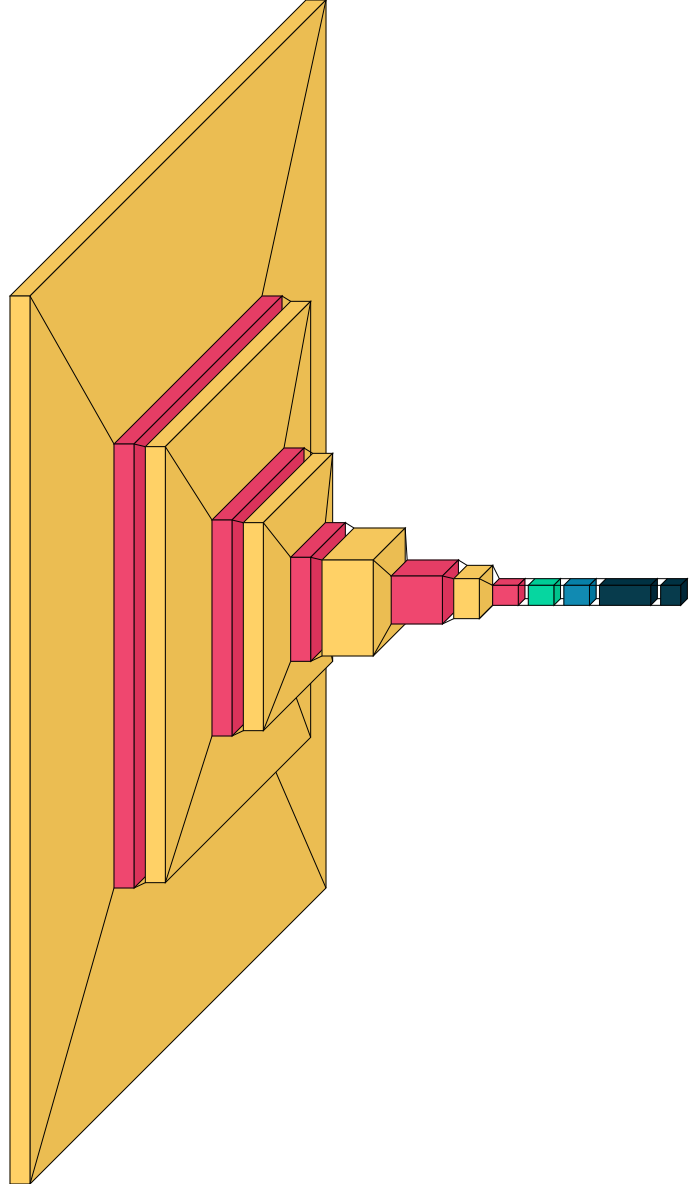

In [ ]:
import visualkeras
from PIL import ImageFont

model = create_model()

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file= os.path.join(visualCnn_path,'cnn_archi.png')) # write to disk '/mnt/d/Undergrad_thesis/new_citrus_leaves'
# visualkeras.layered_view(model, to_file= os.path.join(visualCnn_path,'cnn_archi.png')).show() # write and show

visualkeras.layered_view(model)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Using 'categorical' for multi-class classification
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1956 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 424 images belonging to 4 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/20
61/61 [==============================] - 35s 536ms/step - loss: 0.8349 - accuracy: 0.5946 - val_loss: 0.7219 - val_accuracy: 0.6466 - lr: 6.0000e-04
Epoch 2/20
61/61 [==============================] - 33s 541ms/step - loss: 0.6690 - accuracy: 0.6606 - val_loss: 0.6252 - val_accuracy: 0.6731 - lr: 6.0000e-04
Epoch 3/20
61/61 [==============================] - 32s 523ms/step - loss: 0.6295 - accuracy: 0.6746 - val_loss: 0.6111 - val_accuracy: 0.6707 - lr: 6.0000e-04
Epoch 4/20
61/61 [==============================] - 33s 532ms/step - loss: 0.5364 - accuracy: 0.7069 - val_loss: 0.4867 - val_accuracy: 0.7308 - lr: 6.0000e-04
Epoch 5/20
61/61 [==============================] - 32s 529ms/step - loss: 0.4919 - accuracy: 0.7251 - val_loss: 0.5510 - val_accuracy: 0.7163 - lr: 6.0000e-04
Epoch 6/20
61/61 [==============================] - 33s 537ms/step - loss: 0.4347 - accuracy: 0.7905 - val_loss: 0.4152 - val_accuracy: 0.7812 - lr: 6.0000e-04
Epoch 7/20
61/61 [======================

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weights_path,'NewTrail9784_Custom_cnn2.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 5s 307ms/step - loss: 0.0997 - accuracy: 0.9693
Test Accuracy: 0.9693396091461182


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.9783653616905212
Corresponding Training Accuracy: 0.9595286846160889


In [ ]:
loaded_model = load_model(os.path.join(weights_path,'NewTrail9784_Custom_cnn2.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 4s 246ms/step - loss: 0.0997 - accuracy: 0.9693
Test Accuracy: 0.9693396091461182


14/14 [==============================] - 4s 251ms/step


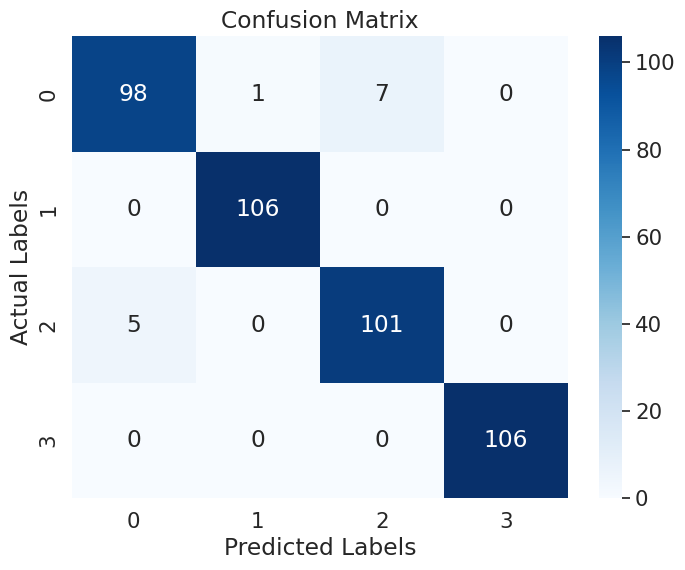

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       106
           1       0.99      1.00      1.00       106
           2       0.94      0.95      0.94       106
           3       1.00      1.00      1.00       106

    accuracy                           0.97       424
   macro avg       0.97      0.97      0.97       424
weighted avg       0.97      0.97      0.97       424



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

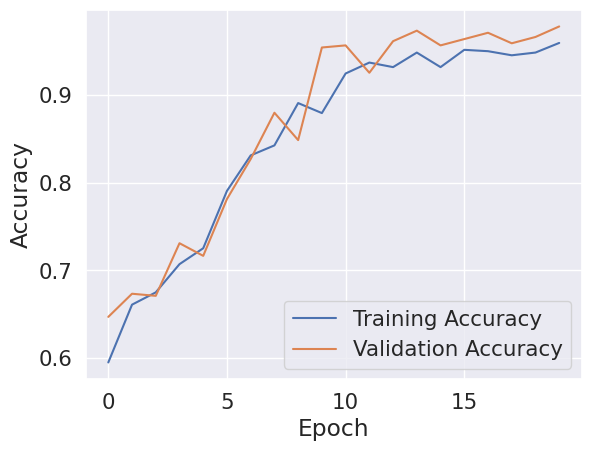

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##NEW TRAIL

In [ ]:
# def create_model():
#     model = Sequential()

#     # Convolutional layers
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     # model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.1))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     # model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))


#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(GlobalAveragePooling2D())

#     # Flatten layer
#     model.add(Flatten())

#     # Dense layers
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(128, activation='relu'))

#     # model.add(Dropout(0.15))  # Dropout for regularization

#     model.add(Dense(4, activation='softmax'))

#     # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#     return model

In [ ]:
# def create_model():
#     model = Sequential()

#     # Convolutional layers
#     model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(224, 224, 3)))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(64, (3, 3), activation='tanh'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='tanh'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(Conv2D(512, (3, 3), activation='tanh'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.1))

#     # model.add(Conv2D(128, (3, 3), activation='relu'))
#     # model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))


#     model.add(Conv2D(256, (3, 3), activation='tanh'))
#     model.add(MaxPooling2D((2, 2)))
#     # model.add(Dropout(0.25))

#     model.add(GlobalAveragePooling2D())

#     # Flatten layer
#     model.add(Flatten())

#     # Dense layers
#     model.add(Dense(512, activation='tanh'))
#     # model.add(Dropout(0.15))  # Dropout for regularization

#     model.add(Dense(4, activation='softmax'))

#     # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#     return model

In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.1))

    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.15))  # Dropout for regularization

    model.add(Dense(4, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 128)     

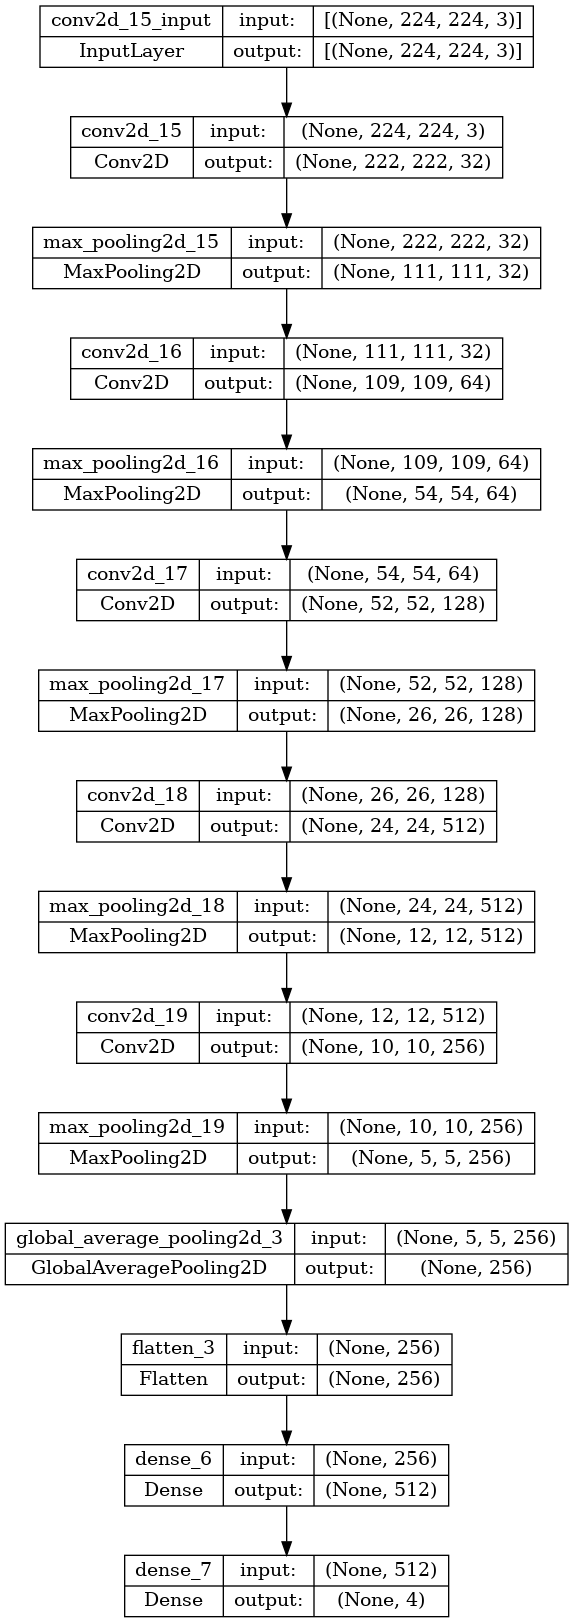

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Using 'categorical' for multi-class classification
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_aug_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1956 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 424 images belonging to 4 classes.


used tanh with 0.0005 and got 0.83

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/20
61/61 [==============================] - 34s 516ms/step - loss: 0.9436 - accuracy: 0.5328 - val_loss: 0.6377 - val_accuracy: 0.6659 - lr: 7.0000e-04
Epoch 2/20
61/61 [==============================] - 33s 535ms/step - loss: 0.6957 - accuracy: 0.6684 - val_loss: 0.6373 - val_accuracy: 0.6947 - lr: 7.0000e-04
Epoch 3/20
61/61 [==============================] - 32s 521ms/step - loss: 0.6601 - accuracy: 0.6939 - val_loss: 0.9454 - val_accuracy: 0.5865 - lr: 7.0000e-04
Epoch 4/20
61/61 [==============================] - 32s 527ms/step - loss: 0.5291 - accuracy: 0.7479 - val_loss: 0.4537 - val_accuracy: 0.7764 - lr: 7.0000e-04
Epoch 5/20
61/61 [==============================] - 31s 511ms/step - loss: 0.5517 - accuracy: 0.7422 - val_loss: 0.5366 - val_accuracy: 0.7212 - lr: 7.0000e-04
Epoch 6/20
61/61 [==============================] - 32s 520ms/step - loss: 0.4443 - accuracy: 0.7646 - val_loss: 0.5052 - val_accuracy: 0.7380 - lr: 7.0000e-04
Epoch 7/20
61/61 [======================

relu train

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]
)

Epoch 1/20
61/61 [==============================] - 33s 509ms/step - loss: 0.9114 - accuracy: 0.5442 - val_loss: 0.7392 - val_accuracy: 0.6466 - lr: 7.0000e-04
Epoch 2/20
61/61 [==============================] - 32s 523ms/step - loss: 0.6452 - accuracy: 0.6700 - val_loss: 0.6110 - val_accuracy: 0.6803 - lr: 7.0000e-04
Epoch 3/20
61/61 [==============================] - 32s 530ms/step - loss: 0.6047 - accuracy: 0.6814 - val_loss: 0.7257 - val_accuracy: 0.6178 - lr: 7.0000e-04
Epoch 4/20
61/61 [==============================] - 33s 531ms/step - loss: 0.6013 - accuracy: 0.7053 - val_loss: 0.6123 - val_accuracy: 0.6899 - lr: 7.0000e-04
Epoch 5/20
61/61 [==============================] - 32s 527ms/step - loss: 0.4789 - accuracy: 0.7308 - val_loss: 0.4534 - val_accuracy: 0.7308 - lr: 7.0000e-04
Epoch 6/20
61/61 [==============================] - 31s 511ms/step - loss: 0.5310 - accuracy: 0.7022 - val_loss: 0.4475 - val_accuracy: 0.7260 - lr: 7.0000e-04
Epoch 7/20
61/61 [======================